# Modelo de Kermack McKendrick

hola

In [1]:
include("Taylor.jl")
using ADT

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-20

1.0e-20

In [4]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [5]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [7]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);

  0.788777 seconds (8.36 M allocations: 154.125 MB, 2.29% gc time)


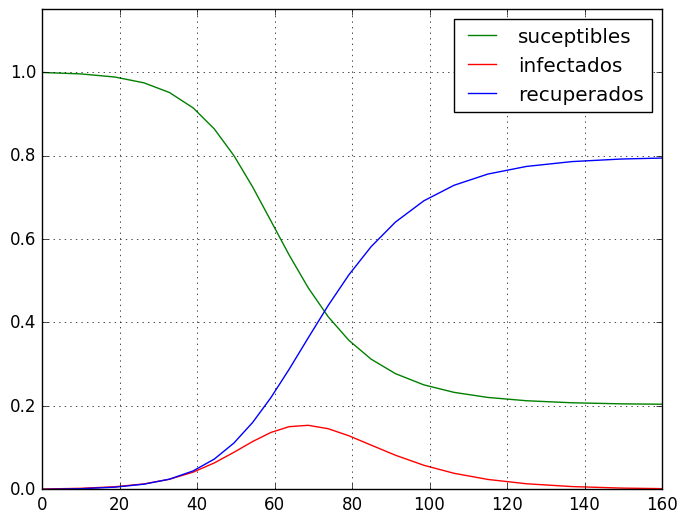

In [8]:
using PyPlot

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [9]:
eps_abs = 1e-50

1.0e-50

In [10]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [13]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

In [14]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 160.
;

In [11]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

3-element Array{Float64,1}:
 0.0359247 
 0.00505131
 0.096875  

In [15]:
t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

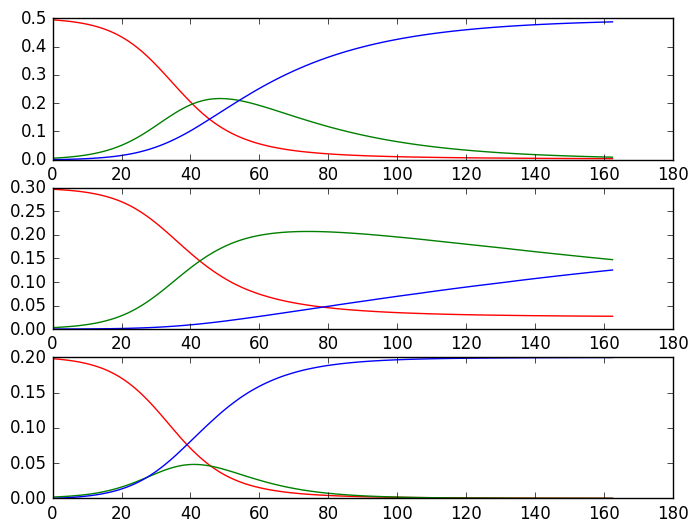

In [16]:
for k = 1:3
    subplot(3,1,k)
plot(t3, s3[k], color = "red")
plot(t3, i3[k], color = "green")
plot(t3, r3[k], color = "blue")
end

In [18]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end

In [19]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [20]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

In [21]:
beta = rand(3,3)/3
gamma = rand(3)/8
phi = rand(3)/3
;

In [23]:
@time t3, s3, i3, r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta, phi);

  5.017151 seconds (166.17 M allocations: 2.686 GB, 3.77% gc time)


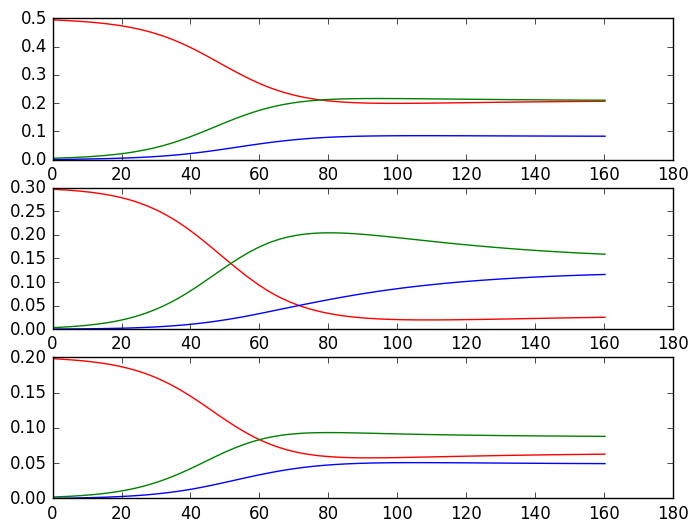

In [24]:
for k = 1:3
    subplot(3,1,k)
plot(t3, s3[k], color = "red")
plot(t3, i3[k], color = "green")
plot(t3, r3[k], color = "blue")
end